# TicTacToe using SARSA Part 1 - Exact States

In this notebook I will try to create a TicTacToe Environment and Agent, while saving all states.

I will be using the SARSA algorithm, which enables the agent to learn after every step using "bootstrapping", instead of waiting for the end of the game ("episode"). You can read more about it in the [Sutton & Barto's book (2nd edition)](https://d3c33hcgiwev3.cloudfront.net/Ph9QFZnEEemRfw7JJ0OZYA_808e8e7d9a544e1eb31ad11069d45dc4_RLbook2018.pdf?Expires=1578700800&Signature=kknv~Fe2hgmHae7aID4u9P9BUwvcIQ2F5qaNopIiaOpjUeiqESW6W4xhnji1Yyf1dEgNg5NvaKCqAOtHPX65N4LFHM3cU-Zj3WQFRl1S~NM79uQSWijIvnCNAIvPVSLct6i5u7Ruc-IkWYDGoPFtyHUWq8iFH1WJBuOZTaw~QzQ_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A), in section 6.5.

I am using a few base classes that I lent from the Coursera courses on Reinforcement Learning - mainly the RLGlue, which I modified. This is used as a glue between an agent and an environment.

In [1]:
from BaseAgent import BaseAgent
from BaseEnvironment import BaseEnvironment
from RLGlue import RLGlue

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [2]:
# reload modules in case I change them
%load_ext autoreload
%autoreload 2

The environment can be modeled as an array of 9 values, reshaped to a 3x3 matrix. 0 means there's no x or O in that square.
The actual player values will be given from the outside (spoiler alert, they will be -1 and +1). I also return a mask that will be used by the agent in the policy action decision to determine which available options it has. The mask has 0 for taken squares, and 1 for free squares.

I give a +10 reward for winning, 0 reward for tie. In order to encourage fast games, I give a reward of -1 for every step that doesn't result in winning. I also give a negative reward of -10 for the agent that lost. 

In [90]:
class TicTacToeEvnironment(BaseEnvironment):
    def env_init(self, env_info={}):
        pass
    
    def env_start(self):
        self.terminal = False
        self.board = np.zeros((3, 3))
        self.reward_obs_term = (0, self.board, False)
        return self.board.copy().reshape(9), self.get_mask()
    
    def env_step(self, agent_num, index):
        if self.terminal:
            print("Environment in terminal state, please restart.")
        
        row, col = self.transform_index(index)
        self.board[row, col] = agent_num
        
        if self.check_won(agent_num):
            reward = 10
            self.terminal = True
        elif self.check_tie():
            reward = 0
            self.terminal = True
        else:
            reward = -1
            
        self.reward_obs_term_mask = (reward, self.board.copy().reshape(9), self.terminal, self.get_mask())
        return self.reward_obs_term_mask
    
    def check_tie(self):
        return (self.board == 0).sum() == 0
    
    def check_won(self, agent_num):
        for row in self.board:
            if np.array_equal(row, agent_num * np.ones((3,))):
                return True
        for col in self.board.T:
            if np.array_equal(col, agent_num * np.ones((3,))):
                return True
        diag = np.diag(self.board)
        if np.array_equal(diag, agent_num * np.ones((3,))):
            return True
        diag = np.diag(np.fliplr(self.board))
        if np.array_equal(diag, agent_num * np.ones((3,))):
            return True
        return False
    
    def env_cleanup(self):
        pass
    
    def env_message(self, message):
        if message == 0:  # return available indices mask
            return self.get_mask()
            
    def get_mask(self):
        rows, cols = np.where(self.board == 0)
        indices = rows * 3 + cols
        mask = np.zeros((9,))
        mask[indices] = 1
        return mask.astype(int)
    
    def transform_index(self, index):
        return index // 3, index % 3

The agent will keep track of all seen states in his Q(s,a) table (called here states). Theoratically, there are 9 squares on the board, and each can contain 3 values (empty, x, or O) , so there can be 3^9 =~ 20k different states. But most of these states are probably not feasible for a game. So it's much better if we simply add every new encountered state to a dictionary.

The policy will choose greedily (online) the best possible action from all available ones. It will break the tie between equally good options arbitrarily. If the state hasn't been encountered yet, all available spaces get same probability to be chosen. 

In [91]:
class TicTacToeAgent(BaseAgent):
    def agent_init(self, agent_init_info):    
        self.learning_step = agent_init_info["learning_step"]
        self.num_actions = agent_init_info["num_actions"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        self.states = {}
        self.last_state = None
        self.last_action = None

    def policy(self, q, mask):
        # greedy policy, breaks ties randomly
        pos = np.exp(q - np.max(q)) * mask
        return self.argmax(pos)

    def argmax(self, array):
        m = np.max(array)
        ind = np.where(array == m)[0]
        return self.rand_generator.choice(ind)
    
    def get_q(self, state, mask):
        if str(state) in self.states:
            q = self.states[str(state)]
        else:
            q = np.zeros_like(state)
            q[mask == 1] = 1
        return q
    
    def agent_start(self, state, mask):
        self.last_state = state
        q = self.get_q(state, mask)
        self.states[str(self.last_state)] = q
        self.last_action = self.policy(q, mask)
        return self.last_action        

    def agent_step(self, reward, state, mask):
        # SARSA
        q = self.get_q(state, mask)
        action = self.policy(q, mask)
        q_s_ = q[action]
        q_s = self.states[str(self.last_state)][self.last_action]
        self.states[str(self.last_state)][self.last_action] += self.learning_step * (reward + q_s_ - q_s)

        self.last_state = state
        self.states[str(self.last_state)] = q
        self.last_action = action
        return action
    
    def agent_end(self, reward):
        # SARSA
        q_s = self.states[str(self.last_state)][self.last_action]
        self.states[str(self.last_state)][self.last_action] += self.learning_step * (reward - q_s)
        
    def agent_message(self, message):
        pass

The experiment will use the environment coupled with 2 agents, one which will change states from 0 to -1, and the other from 0 to +1. 

In [97]:
def experiment(runs):
    rlglue = RLGlue(TicTacToeEvnironment, TicTacToeAgent, TicTacToeAgent)
    rewards = np.zeros((runs, 2))
    starts = np.zeros((runs, 1))
    final_states = np.zeros((runs, 9))
    agent1_info = {"learning_step": 1, "num_actions": 9, "seed": 12}
    agent2_info = {"learning_step": 1, "num_actions": 9, "seed": 17}
    env_info = {}
    rlglue.rl_init(agent1_info, agent2_info, env_info)

    for i in tqdm(range(runs)):
        rlglue.rl_episode(10)
        rewards[i, :], starts[i, :], final_states[i, :] =  rlglue.rl_return()
    return rlglue, rewards, starts, final_states

In [99]:
rlg, rew, starts, states = experiment(30000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:47<00:00, 210.87it/s]


Let's see how the last 100 games rewards were for both players 

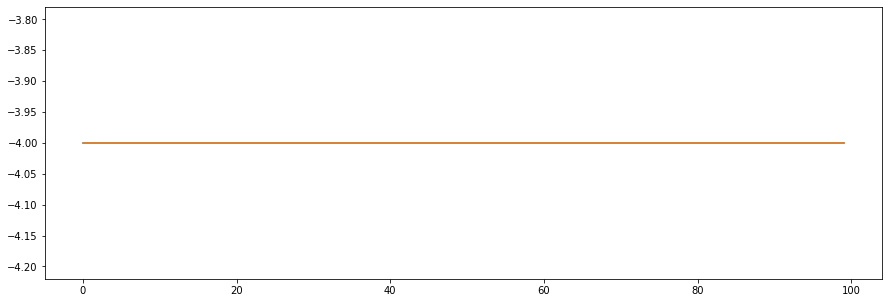

In [129]:
plt.figure(figsize=(15,5))
plt.plot(rew[-100:,])
plt.show()

The agents reach a deadlock of tie against each other after around 30k episodes! This actually improves over time, after 10k agents tie, but not always, and it improves for 20k.

In [147]:
# agent1 wins, agent2 wins
(rew[:,0] > 0).sum() , (rew[:,1] > 0).sum()

(13, 9)

Both agents win only a miniscule fraction of games... 

Now let's play against an AI agent

In [130]:
env = TicTacToeEvnironment()
env.env_init()
ret = env.env_start()

In [131]:
ai = rlg.agents[-1]["agent"]

In [132]:
action = ai.agent_start(ret[0], ret[1])

In [133]:
action

2

In [134]:
ret = env.env_step(-1, action) # ai

In [135]:
ret = env.env_step(1, 4) # me

What returns: reward, state, terminal, mask; 
The agent_step needs reward, state and mask - I put the reward manually just for no reason

In [136]:
action = ai.agent_step(-1, ret[1], ret[3]) 
action

5

In [137]:
ret = env.env_step(-1, action)

In [138]:
ret = env.env_step(1, 8)

In [139]:
action = ai.agent_step(-1, ret[1], ret[3])
action

0

In [142]:
ret = env.env_step(-1, action)

In [143]:
ret = env.env_step(1, 7)

In [144]:
action = ai.agent_step(-1, ret[1], ret[3])
action

1

In [145]:
env.env_step(-1, action)

(10,
 array([-1., -1., -1.,  0.,  1., -1.,  0.,  1.,  1.]),
 True,
 array([0, 0, 0, 1, 0, 0, 1, 0, 0]))

ai wins ! (reward of 10 for it's move)

In [146]:
# lets save this agent
fw = open('agent-exact-states', 'wb')
pickle.dump(ai.states, fw)
fw.close()

In [141]:
# how many unique states are there?
len(ai.states)

4484

So we see that even though theoratically there could be a maximum 20k states, in reality the agents only saw less than 5k states. 

This was good - we now have an agent that can probably beat us in Tic-Tac-Toe and it was trained pretty fast. The only downside is that we had to save all the states that the evnironment could produce. For Tic-Tac-Toe this isn't bad, but for more complex scenarios it can become unfeasable. So can we do better?

Let's see in part 2. 